In [1]:
# Plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}


# Neural network for multi regression
from numpy import loadtxt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import ceil, pi
import random
from random import sample
from sklearn.model_selection import RepeatedKFold
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import h5py # For model saving: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
import sklearn

In [2]:
model = load_model('best_model_regression_dk.h5')

train = pd.read_csv('train.csv')
#validation = pd.read_csv('validation.csv')
test = pd.read_csv('test.csv')


train['C0_norm'] = (train.C0*-1 - min(train.C0*-1))/(max(train.C0*-1) - min(train.C0*-1))
test['C0_norm'] = (test.C0*-1 - min(train.C0*-1))/(max(train.C0*-1) - min(train.C0*-1))
#validation['C0_norm'] = (validation.C0*-1 - min(train.C0*-1))/(max(train.C0*-1) - min(train.C0*-1))

train['lam_norm'] = (train.lam_dim - min(train.lam_dim))/(max(train.lam_dim) - min(train.lam_dim))
test['lam_norm'] = (test.lam_dim - min(train.lam_dim))/(max(train.lam_dim) - min(train.lam_dim))
#validation['lam_norm'] = (validation.lam_dim - min(train.lam_dim))/(max(train.lam_dim) - min(train.lam_dim))

train['delta_norm'] = (train.delta - min(train.delta))/(max(train.delta) - min(train.delta))
test['delta_norm'] = (test.delta - min(train.delta))/(max(train.delta) - min(train.delta))
#validation['delta_norm'] = (validation.delta - min(train.delta))/(max(train.delta) - min(train.delta))

train['rad_norm'] = (train.rad - min(train.rad))/(max(train.rad) - min(train.rad))
#validation['rad_norm'] = (validation.rad - min(train.rad))/(max(train.rad) - min(train.rad))
test['rad_norm'] = (test.rad - min(train.rad))/(max(train.rad) - min(train.rad))


In [3]:
features = ['C0_norm', 'rad_norm', 'delta_norm', 'lam_norm']
preds = model.predict(test[features])

Coefficient of determination (r2): 0.021


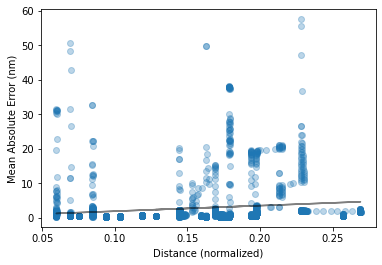

In [4]:
errs = []
dists = []

for i in np.asarray(test.index):
    dist = min(np.abs(train.C0_norm - test.C0_norm[i]) + np.abs(train.lam_norm - test.lam_norm[i]) + np.abs(train.rad_norm - test.rad_norm[i]) + np.abs(train.delta_norm - test.delta_norm[i])) # This is just the L1 or Manhattan/Minkowski metric. 
    dists.append(dist)
    # As the dimension of parameter space increases, using norms like the Manhattan norm is more effective at differentiating distance between
    # points: https://towardsdatascience.com/the-surprising-behaviour-of-distance-metrics-in-high-dimensions-c2cb72779ea6
    err = mean_absolute_error(preds[i], test.iloc[i,-104:-4])
    errs.append(err)
    
errs_df = pd.DataFrame({'Errors': errs, "Distances": dists}) 

plt.scatter(dists, errs, alpha = .3)
plt.xlabel('Distance (normalized)')
plt.ylabel('Mean Absolute Error (nm)')

reg = LinearRegression().fit(np.array(dists).reshape(-1, 1), np.array(errs).reshape(-1, 1))
score = reg.score(np.array(dists).reshape(-1, 1), np.array(errs).reshape(-1, 1))
reg_preds = reg.predict(np.array(dists).reshape(-1, 1))
plt.plot(np.array(dists).reshape(-1, 1), reg_preds, c = 'black', alpha = .5)
print("Coefficient of determination (r2): " + str(round(score, 3)))

In [5]:
# Calculate errors based on x and y locations being divided by their maximums to provide some normalization for size.
# We'll scale only by validation maxes so that the predictions don't get an artificial reduction in error from being rescaled to max out at one. 

norm_errs = []
low_ran = -104
up_ran = -4

for i in np.arange(0,len(test)): 
    xs = test.iloc[i, low_ran : low_ran + 50]
    ys = test.iloc[i, low_ran + 50 : up_ran]
    
    if xs.max() > 10 and ys.max() > 10: # Only consider where the bilayer is somewhat deformed 
        x_data_norm = xs/(xs.max())
        y_data_norm = ys/(ys.max())

        x_preds_norm = preds[test.index[i], 0:50]/xs.max() 
        y_preds_norm = preds[test.index[i], 50:100]/ys.max() 

        inner_errs = []
        for j in np.arange(0,50):
            xer = (x_data_norm - x_preds_norm[j])
            yer = (y_data_norm - y_preds_norm[j])
            
            eu_err = ((np.array(xer)**2 + np.array(yer)**2)**(1/2)).min()
        
            inner_errs.append(eu_err)
        
        norm_errs.append(np.mean(inner_errs))
                
    else: 
        norm_errs.append(np.nan)
        
errs_df['norm_Errors'] = norm_errs
test['Errors'] = errs_df.Errors
test['Distances'] = errs_df.Distances
test['norm_Errors'] = errs_df.norm_Errors

In [6]:
errs_df['omega'] = test.omega

/opt/anaconda3/envs/muscleLengthPrediction_env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/muscleLengthPrediction_env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/muscleLengthPrediction_env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit

Coefficient of determination (r2): 0.158
Coefficient of determination (r2): 0.01


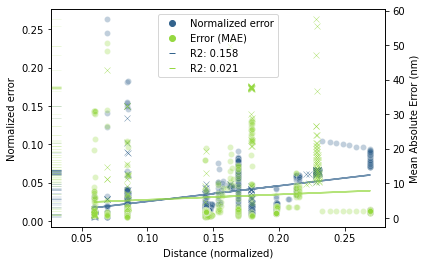

In [7]:
bcol = "#33638DFF"
gcol = "#95D840FF"

temp = errs_df.dropna(how = 'any') # filters out some nans
temp = temp.where(temp.omega != -1).dropna(how = 'all')
temp_hill = temp.where(temp.omega == 0).dropna(how = 'all')
temp_omega = temp.where(temp.omega == 1).dropna(how = 'all')

reg_scatter = sns.scatterplot(temp_hill.Distances, temp_hill['norm_Errors'], alpha = .3, marker = 'o', color = bcol)#, label = 'Normalized error')
sns.scatterplot(temp_omega.Distances, temp_omega['norm_Errors'], alpha = .75, marker = 'x', color = bcol)

sns.rugplot(data=temp_omega, y='norm_Errors', color = bcol, alpha=.1, height=.03, expand_margins = False) #, ax=reg_scatter.axes.twinx())

plt.xlabel('Distance (normalized)')
plt.ylabel('Normalized error')

reg = LinearRegression().fit(np.array(temp.Distances).reshape(-1,1), np.array(temp.norm_Errors).reshape(-1,1)) 
score_norm = reg.score(np.array(temp.Distances).reshape(-1, 1), np.array(temp.norm_Errors).reshape(-1, 1))
reg_preds = reg.predict(np.array(temp.Distances).reshape(-1, 1))

plt.plot(np.array(temp.Distances).reshape(-1, 1), reg_preds, c = bcol, alpha = .7)
print("Coefficient of determination (r2): " + str(round(score_norm, 3)))

sns.scatterplot(temp_hill.Distances, temp_hill['Errors'], marker = 'o', alpha = .3, color = gcol, ax=reg_scatter.axes.twinx())#, label = 'MAE')
sns.scatterplot(temp_omega.Distances, temp_omega['Errors'], marker = 'x', alpha = .75, color = gcol)#, ax=reg_scatter.axes.twinx())

sns.rugplot(data=temp_omega, y='Errors', color = gcol, alpha=.1, height=.03, expand_margins = False) #, ax=reg_scatter.axes.twinx())

plt.ylabel('Mean Absolute Error (nm)')

reg = LinearRegression().fit(np.array(temp.Distances).reshape(-1, 1), np.array(temp['Errors']).reshape(-1, 1))
score_Er = reg.score(np.array(temp.Distances).reshape(-1, 1), np.array(temp['Errors']).reshape(-1, 1))
reg_preds = reg.predict(np.array(temp.Distances).reshape(-1, 1))

plt.plot(np.array(temp.Distances).reshape(-1, 1), reg_preds, c = gcol, alpha = .7)
print("Coefficient of determination (r2): " + str(round(score_Er, 3)))


custom = [Line2D([], [], marker='o', color=bcol, linestyle='None', label = 'Normalized error'),
          Line2D([], [], marker='o', color=gcol, linestyle='None', label = 'Error (MAE)'),
          Line2D([], [], marker='_', color=bcol, linestyle='None', label = 'R2: ' + str(round(score_norm, 3))),
          Line2D([], [], marker='_', color=gcol, linestyle='None', label = 'R2: ' + str(round(score_Er, 3))),]


#fig = plt.figure(figsize=(8,5))

plt.legend(custom, ['Normalized error', 'Error (MAE)', 'R2: ' + str(round(score_norm, 3)), 'R2: ' + str(round(score, 3))]) #, ['Normalized error', 'Error (MAE)'], loc='lower right')
#plt.savefig('RegressionErrorDistanceRegression_dk_Test.png')
#plt.savefig('RegressionErrorDistanceRegression_dk_Test.pdf')

/opt/anaconda3/envs/muscleLengthPrediction_env/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


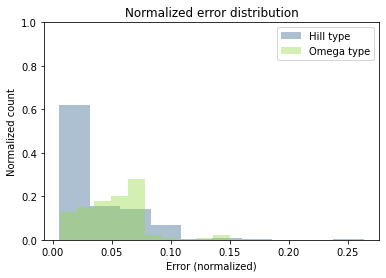

/opt/anaconda3/envs/muscleLengthPrediction_env/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


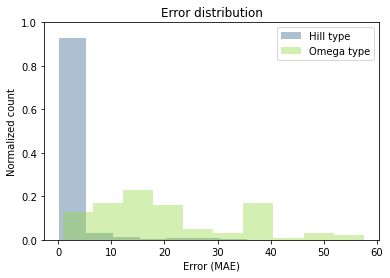

/opt/anaconda3/envs/muscleLengthPrediction_env/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


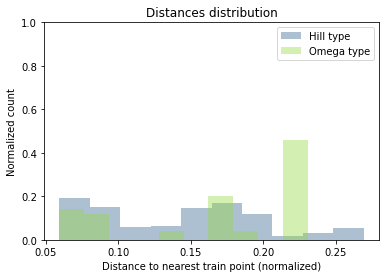

In [8]:

val_sub_omega = test.where(test.omega == 1).dropna(how = 'all')
val_sub_hill = test.where(test.omega == 0).dropna(how = 'all')

errs = errs_df.loc[val_sub_hill.index].norm_Errors.dropna(how = 'all').reset_index(drop = 'True')
sns.distplot(errs, bins = 10, kde=False, color = bcol,
             hist_kws={'weights': np.full(len(errs), 1/len(errs))}, label = 'Hill type')

errs = errs_df.loc[val_sub_omega.index].norm_Errors.dropna(how = 'all').reset_index(drop = 'True')
sns.distplot(errs, bins = 10, kde=False, color=gcol,
             hist_kws={'weights': np.full(len(errs), 1/len(errs))}, label = 'Omega type')

plt.xlabel('Error (normalized)')
plt.ylabel('Normalized count')
plt.title('Normalized error distribution')
plt.ylim(0,1)
plt.legend()
#plt.savefig('Distribution_normErrors_dk_Test.pdf')
#plt.savefig('Distribution_normErrors_dk_Test.png')
plt.show()



errs = errs_df.loc[val_sub_hill.index].Errors.dropna(how = 'all').reset_index(drop = 'True')
sns.distplot(errs, bins = 10, kde=False, color = bcol,
             hist_kws={'weights': np.full(len(errs), 1/len(errs))}, label = 'Hill type')

errs = errs_df.loc[val_sub_omega.index].Errors.dropna(how = 'all').reset_index(drop = 'True')
sns.distplot(errs, bins = 10, kde=False,  color=gcol,
             hist_kws={'weights': np.full(len(errs), 1/len(errs))}, label = 'Omega type')
plt.xlabel('Error (MAE)')
plt.ylabel('Normalized count')
plt.ylim(0,1)
plt.title('Error distribution')
plt.legend()
#plt.savefig('Distribution_Errors_dk_Test.pdf')
#plt.savefig('Distribution_Errors_dk_Test.png')
plt.show()


errs = errs_df.loc[val_sub_hill.index].Distances.dropna(how = 'all').reset_index(drop = 'True')
sns.distplot(errs, bins = 10, kde=False, color = bcol,
             hist_kws={'weights': np.full(len(errs), 1/len(errs))}, label = 'Hill type')

errs = errs_df.loc[val_sub_omega.index].Distances.dropna(how = 'all').reset_index(drop = 'True')
sns.distplot(errs, bins = 10, kde=False, color=gcol,
             hist_kws={'weights': np.full(len(errs), 1/len(errs))}, label = 'Omega type')

plt.xlabel('Distance to nearest train point (normalized)')
plt.ylabel('Normalized count')
plt.title('Distances distribution')
plt.ylim(0,1)
plt.legend()
#plt.savefig('Distribution_Distances_dk_Test.pdf')
#plt.savefig('Distribution_Distances_dk_Test.png')
plt.show()

In [10]:
test_omegas = test.where(test.omega == 1).dropna(how = 'all')
test_not_omegas = test.where(test.omega == 0).dropna(how = 'all')

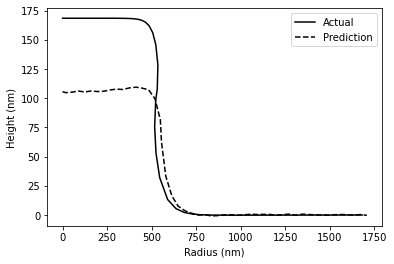

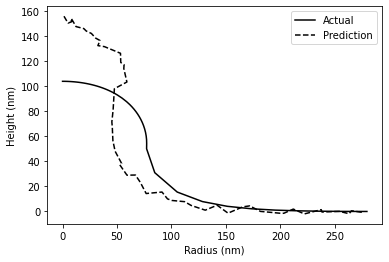

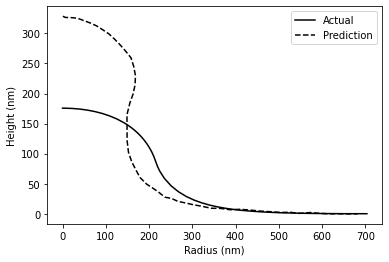

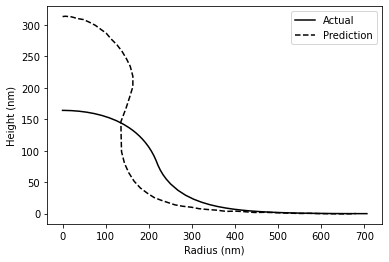

In [11]:
# Plot the maximum errors for an omega and not omega classed bud

temp = test_omegas.where(test_omegas.Errors == test_omegas.Errors.max()).dropna(how = 'all').iloc[0]
temp_ind = test_omegas.where(test_omegas.Errors == test_omegas.Errors.max()).dropna(how = 'all').index[0]
plt.plot(temp[-107:-57], temp[-57:-7], c = 'black', label = 'Actual')
plt.plot(preds[temp_ind, 0:50], preds[temp_ind, 50:100], c = 'black', linestyle = '--', label = 'Prediction')
plt.legend()
plt.xlabel('Radius (nm)')
plt.ylabel('Height (nm)')
plt.savefig('MaxError_Omega_dk.png')
plt.savefig('MaxError_Omega_dk.pdf')
plt.show()


####

temp = test_omegas.where(test_omegas.norm_Errors == test_omegas.norm_Errors.max()).dropna(how = 'all').iloc[0]
temp_ind = test_omegas.where(test_omegas.norm_Errors == test_omegas.norm_Errors.max()).dropna(how = 'all').index[0]
plt.plot(temp[-107:-57], temp[-57:-7], c = 'black', label = 'Actual')
plt.plot(preds[temp_ind, 0:50], preds[temp_ind, 50:100], c = 'black', linestyle = '--', label = 'Prediction')
plt.legend()
plt.xlabel('Radius (nm)')
plt.ylabel('Height (nm)')
plt.savefig('MaxNormError_Omega_dk.png')
plt.savefig('MaxNormError_Omega_dk.pdf')
plt.show()


####


temp = test_not_omegas.where(test_not_omegas.Errors == test_not_omegas.Errors.max()).dropna(how = 'all').iloc[0]
temp_ind = test_not_omegas.where(test_not_omegas.Errors == test_not_omegas.Errors.max()).dropna(how = 'all').index[0]
plt.plot(temp[-107:-57], temp[-57:-7], c = 'black', label = 'Actual')
plt.plot(preds[temp_ind, 0:50], preds[temp_ind, 50:100], c = 'black', linestyle = '--', label = 'Prediction')
plt.legend()
plt.xlabel('Radius (nm)')
plt.ylabel('Height (nm)')
plt.savefig('MaxError_NotOmega_dk.png')
plt.savefig('MaxError_NotOmega_dk.pdf')
plt.show()


####

temp = test_not_omegas.where(test_not_omegas.norm_Errors == test_not_omegas.norm_Errors.max()).dropna(how = 'all').iloc[0]
temp_ind = test_not_omegas.where(test_not_omegas.norm_Errors == test_not_omegas.norm_Errors.max()).dropna(how = 'all').index[0]
plt.plot(temp[-107:-57], temp[-57:-7], c = 'black', label = 'Actual')
plt.plot(preds[temp_ind, 0:50], preds[temp_ind, 50:100], c = 'black', linestyle = '--', label = 'Prediction')
plt.legend()
plt.xlabel('Radius (nm)')
plt.ylabel('Height (nm)')
plt.savefig('MaxNormError_NotOmega_dk.png')
plt.savefig('MaxNormError_NotOmega_dk.pdf')

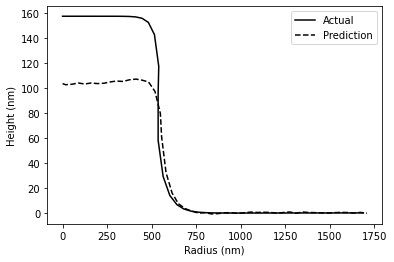

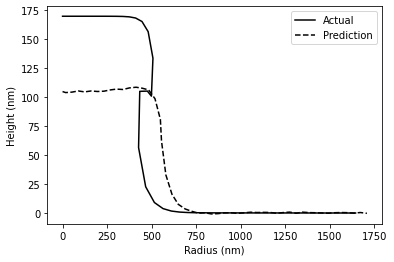

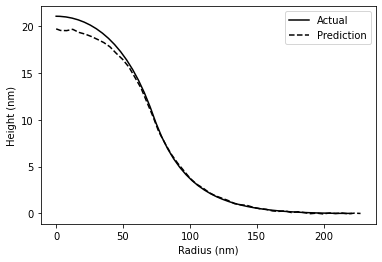

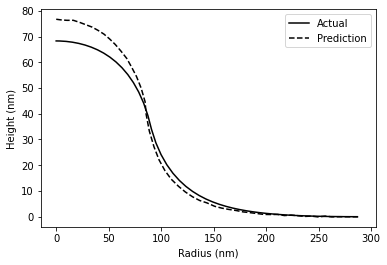

In [12]:
# Plot the closest to mean error for an omega and not omega classed bud
temp_ind = (test_omegas.Errors - test_omegas.Errors.mean()).abs().idxmin()
temp = test_omegas.loc[temp_ind]
plt.plot(temp[-107:-57], temp[-57:-7], c = 'black', label = 'Actual')
plt.plot(preds[temp_ind, 0:50], preds[temp_ind, 50:100], c = 'black', linestyle = '--', label = 'Prediction')
plt.legend()
plt.xlabel('Radius (nm)')
plt.ylabel('Height (nm)')
plt.savefig('MeanError_Omega_dk.png')
plt.savefig('MeanError_Omega_dk.pdf')
plt.show()

####

temp_ind = (test_omegas.norm_Errors - test_omegas.norm_Errors.mean()).abs().idxmin()
temp = test_omegas.loc[temp_ind]
plt.plot(temp[-107:-57], temp[-57:-7], c = 'black', label = 'Actual')
plt.plot(preds[temp_ind, 0:50], preds[temp_ind, 50:100], c = 'black', linestyle = '--', label = 'Prediction')
plt.legend()
plt.xlabel('Radius (nm)')
plt.ylabel('Height (nm)')
plt.savefig('MeanNormError_Omega_dk.png')
plt.savefig('MeanNormError_Omega_dk.pdf')
plt.show()

####

temp_ind = (test_not_omegas.Errors - test_not_omegas.Errors.mean()).abs().idxmin()
temp = test_not_omegas.loc[temp_ind]
plt.plot(temp[-107:-57], temp[-57:-7], c = 'black', label = 'Actual')
plt.plot(preds[temp_ind, 0:50], preds[temp_ind, 50:100], c = 'black', linestyle = '--', label = 'Prediction')
plt.legend()
plt.xlabel('Radius (nm)')
plt.ylabel('Height (nm)')
plt.savefig('MeanError_NotOmega_dk.png')
plt.savefig('MeanError_NotOmega_dk.pdf')
plt.show()

####

temp_ind = (test_not_omegas.norm_Errors - test_not_omegas.norm_Errors.mean()).abs().idxmin()
temp = test_not_omegas.loc[temp_ind]
plt.plot(temp[-107:-57], temp[-57:-7], c = 'black', label = 'Actual')
plt.plot(preds[temp_ind, 0:50], preds[temp_ind, 50:100], c = 'black', linestyle = '--', label = 'Prediction')
plt.legend()
plt.xlabel('Radius (nm)')
plt.ylabel('Height (nm)')
plt.savefig('MeanNormError_NotOmega_dk.png')
plt.savefig('MeanNormError_NotOmega_dk.pdf')

In [ ]:
# More traces

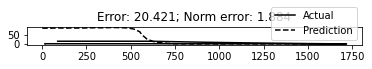

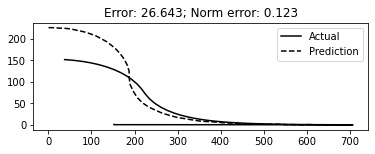

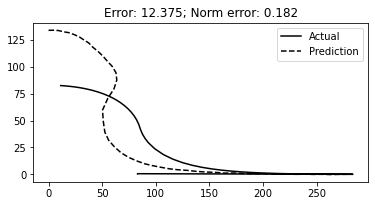

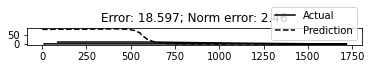

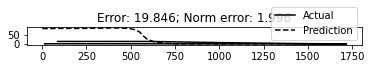

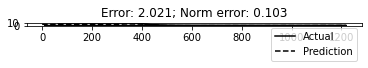

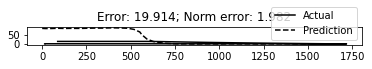

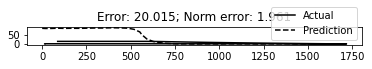

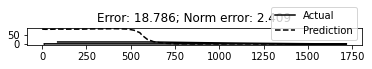

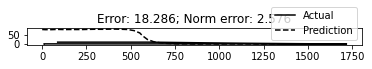

In [13]:
errs_df.where(errs_df.norm_Errors > .1).dropna(how = 'all')
sample_high_norm_err = sample(set(errs_df.where(errs_df.norm_Errors > .1).dropna(how = 'all').index), 10)

for i in sample_high_norm_err:
    plt.plot(test.loc[i][low_ran:low_ran + 50], test.loc[i][low_ran + 50:up_ran], c = 'black', label = 'Actual')
    #plt.plot(-1*test.loc[i][low_ran:low_ran + 50], test.loc[i][low_ran + 50:up_ran], c = 'black')
    plt.plot(preds[i, 0:50], preds[i, 50:100], c = 'black', linestyle = '--', label = 'Prediction')
    #plt.plot(-1*preds[i, 0:50], preds[i, 50:100], c = 'black', linestyle = '--')
    plt.title('Error: ' + str(round(errs_df.Errors.iloc[i], 3)) + '; Norm error: ' + str(round(errs_df.norm_Errors.iloc[i], 3)))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.draw()
    plt.savefig('HighNormError' + str(i) + '_dk.pdf')
    plt.savefig('HighNormError' + str(i) + '_dk.png')
    plt.show()
    

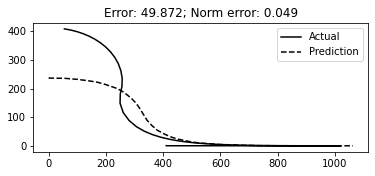

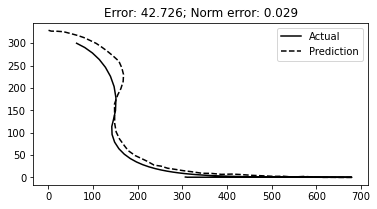

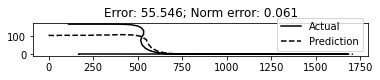

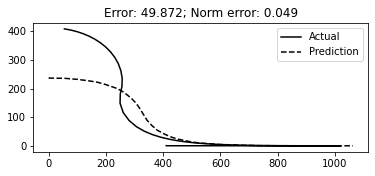

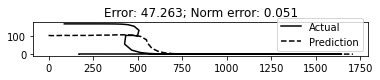

In [19]:
cutoff = 40  
errs_df.where(errs_df.Errors > cutoff).dropna(how = 'all')
sample_high_err = sample(set(errs_df.where(errs_df.Errors > cutoff).dropna(how = 'all').index), 5)

for i in sample_high_err:
    plt.plot(test.loc[i][low_ran:low_ran + 50], test.loc[i][low_ran + 50:up_ran], c = 'black', label = 'Actual')
    plt.plot(preds[i, 0:50], preds[i, 50:100], c = 'black', linestyle = '--', label = 'Prediction')
    plt.title('Error: ' + str(round(errs_df.Errors.iloc[i], 3)) + '; Norm error: ' + str(round(errs_df.norm_Errors.iloc[i], 3)))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.draw()
    plt.savefig('HighError' + str(i) + '_dk.pdf')
    plt.savefig('HighError' + str(i) + '_dk.png')
    plt.show()
    

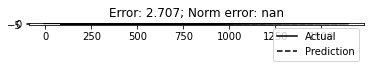

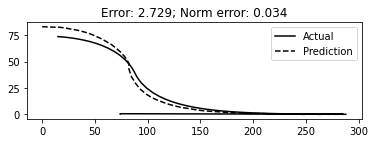

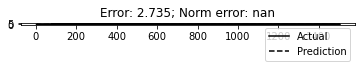

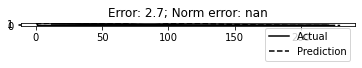

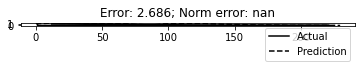

In [20]:
mean_err_inds = errs_df.Errors.where(round(errs_df.Errors, 1) ==  round(errs_df.Errors.mean(), 1)).dropna(how = 'all').index

sample_mean_err = mean_err_inds# sample(set(mean_err_inds), 5)

for i in sample_mean_err:
    plt.plot(test.loc[i][low_ran:low_ran + 50], test.loc[i][low_ran + 50:up_ran], c = 'black', label = 'Actual')
    plt.plot(preds[i, 0:50], preds[i, 50:100], c = 'black', linestyle = '--', label = 'Prediction')
    plt.title('Error: ' + str(round(errs_df.Errors.iloc[i], 3)) + '; Norm error: ' + str(round(errs_df.norm_Errors.iloc[i], 3)))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.draw()
    plt.savefig('MeanError' + str(i) + '_dk.pdf')
    plt.savefig('MeanError' + str(i) + '_dk.png')
    plt.show()
    

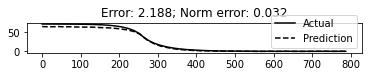

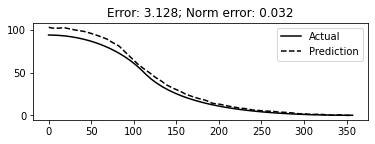

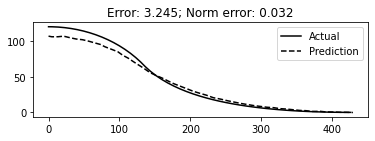

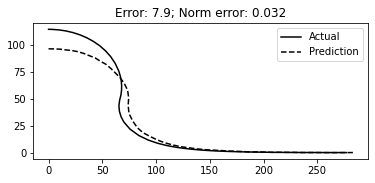

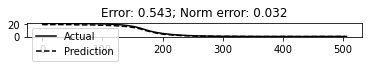

In [41]:
mean_err_inds = errs_df.where(round(errs_df.norm_Errors, 3) ==  round(errs_df.norm_Errors.mean(), 3)).dropna(how = 'all').index

sample_mean_err = sample(set(mean_err_inds), 5)

for i in sample_mean_err:
    plt.plot(validation.loc[i][low_ran:low_ran + 50], validation.loc[i][low_ran + 50:up_ran], c = 'black', label = 'Actual')
    plt.plot(preds[i, 0:50], preds[i, 50:100], c = 'black', linestyle = '--', label = 'Prediction')
    plt.title('Error: ' + str(round(errs_df.Errors.iloc[i], 3)) + '; Norm error: ' + str(round(errs_df.norm_Errors.iloc[i], 3)))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.draw()
    plt.savefig('MeanNormError' + str(i) + '_dk.pdf')
    plt.savefig('MeanNormError' + str(i) + '_dk.png')
    plt.show()
    
